<a href="https://colab.research.google.com/github/junhuk1113/AIAD_weather/blob/master/custom_gan_3_2(cuda_and_torch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import library

import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image as Img
import matplotlib.pyplot as plt
import random

from IPython.display import Image

from skimage import io, transform
import imageio
import datetime
import os
import cv2

#import keras

import keras 
from keras import Input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import Model, layers
from keras.callbacks import *
from keras.models import load_model, model_from_json
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop

%matplotlib inline


In [2]:
#torch and cuda import

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.transforms as T

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


call_cuda = torch.cuda.is_available()
device = torch.device("cuda" if call_cuda else "cpu")

In [3]:
#test on torch bring GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Shape of training data: (31, 24, 64, 64)
Data type: <class 'numpy.ndarray'>
<class 'numpy.uint8'>


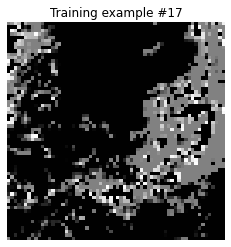

In [5]:
image_size = 64
DATA_DIR = '/content/drive/MyDrive/PBL_Shared_Data/202101cldcr200re64new.npy'
X_train = np.load(DATA_DIR)
print(f"Shape of training data: {X_train.shape}")
print(f"Data type: {type(X_train)}")

print(type(X_train[0][0][0][0]))

data = X_train.astype(np.float64)
data = 255 * data
img = data.astype(np.uint8)
X_train = img

random_image = random.randint(0, len(X_train))
plt.imshow(X_train[random_image,0],cmap='gray',vmin=0,vmax=255)
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

In [6]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("사용하는 Device : ", DEVICE)

current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('%Y-%m-%d-%H:%M')

saved_loc = os.path.join('/content/drive/MyDrive/GAN_Result', current_time)
if os.path.exists(saved_loc):
    shutil.rmtree(saved_loc)
os.mkdir(saved_loc)

print("저장 위치: ", saved_loc)

image_loc = os.path.join(saved_loc, "images")
os.mkdir(image_loc)

writer = SummaryWriter(saved_loc)

EPOCHS = 32
BATCH_SIZE = 200

사용하는 Device :  cuda
저장 위치:  /content/drive/MyDrive/GAN_Result/2022-10-11-20:53


In [7]:
data = X_train.astype(np.float64)
data = 255 * data
X_train = data.astype(np.uint8)

In [8]:
print(type(X_train[0][0][0][0]))

<class 'numpy.uint8'>


In [9]:
#Class Define CloudDataset1
class CloudDataset1(Dataset):
  def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)
  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.X[index]
        X = self.transform(image)
        return X
        transform = T.Compose([
        T.ToPILImage(),
        T.Resize(image_size),
        T.ToTensor()])
# Transformer code
transform = T.Compose([
        T.ToPILImage(),
        T.Resize(image_size),
        T.ToTensor()])

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

In [21]:
#Class Define CloudDataset2
class CloudDataset2(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, ims):
        'Initialization'
        self.ims = ims
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ims)
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.ims[index]
        X = self.transform(image)
        return X
        
transform = T.Compose([
      T.ToPILImage(),
      T.CenterCrop(0.75 * 64),
      T.Resize(image_size),
      T.RandomResizedCrop(image_size),
      T.RandomHorizontalFlip(),
      T.ToTensor()])
    
batch_size = 64
cropped_dataset = CloudDataset2(ims=X_train)
train_dl = DataLoader(cropped_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
#show_batch(train_dl)

In [20]:
sample, label = next(iter(trainloader))

# show grid image
def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()


imshow_grid(sample[0:8])

# Loading trainset, testset and trainloader, testloader

TypeError: ignored

In [ ]:
# Discriminator class
class Dis_model(nn.Module):
    def __init__(self, image_size, hidden_space):
        super(Dis_model, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(image_size, hidden_space),
            nn.ReLU(),
            nn.Linear(hidden_space, hidden_space),
            nn.ReLU(),
            nn.Linear(hidden_space, 1),
            nn.Sigmoid())
    
    def forward(self, input_x):
        x = self.features(input_x)
        return x

In [ ]:
# Generator class
class Gen_model(nn.Module):
    def __init__(self, latent_space, hidden_space, image_size):
        super(Gen_model, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(latent_space, hidden_space),
            nn.ReLU(),
            nn.Linear(hidden_space, hidden_space),
            nn.ReLU(),
            nn.Linear(hidden_space, image_size),
            nn.Tanh())
        
    def forward(self, input_x):
        x = self.features(input_x)
        return x

In [ ]:
im_size = 784
hidden_size = 256
latent_size = 100

Dis_net = Dis_model(image_size = im_size, hidden_space = hidden_size).to(DEVICE)
Gen_net = Gen_model(image_size = im_size, hidden_space = hidden_size, latent_space = latent_size).to(DEVICE)

d_optimizer = optim.Adam(Dis_net.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(Gen_net.parameters(), lr = 0.0002)

fixed_noise = torch.randn(10, latent_size, 1, 1, device = DEVICE)

In [ ]:
#train model,train version

def train(generator, discriminator, train_loader, optimizer_d, optimizer_g):
    generator.train()
    discriminator.train()

    D_losses = []
    G_losses = []

    for data, target in train_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)

        #optimize discriminator

        # initialize discriminator optimizer
        optimizer_d.zero_grad()

        # Make noise samples for discriminator update
        noise_samples_d = torch.randn(BATCH_SIZE, latent_size).to(DEVICE)

        # real loss
        discri_value = discriminator(data.view(-1, 28*28))
        loss_real = -1 * torch.log(discri_value) # gradient ascent

        # fake loss
        gene_value = discriminator(generator(noise_samples_d))
        loss_fake = -1 * torch.log(1.0 - gene_value) # gradient ascent

        # Final loss
        loss_d = (loss_real + loss_fake).mean()

        loss_d.backward()
        optimizer_d.step()


        #optimize generator

        # initialize generator optimizer
        optimizer_g.zero_grad()

        # Make noise samples for generator update
        noise_samples_g = torch.randn(BATCH_SIZE, latent_size).to(DEVICE)

        # calculate loss
        fake_value = discriminator(generator(noise_samples_g))
        loss_generator = -1 * torch.log(fake_value).mean() # provide much stronger gradients early in learning.
        
        loss_generator.backward()
        optimizer_g.step()

    D_loss_epoch = torch.mean(torch.FloatTensor(D_losses))
    G_loss_epoch = torch.mean(torch.FloatTensor(G_losses))
    writer.add_scalars("Train", {"Average Discriminator loss per epoch" : D_loss_epoch.item(),
                                 "Average Generator loss per epoch" : G_loss_epoch.item()}, epoch)

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    train(Gen_net, Dis_net, trainloader, d_optimizer, g_optimizer)

    fixed_noise_generation = Gen_net(fixed_noise.view(-1, latent_size))
    torchvision.utils.save_image(fixed_noise_generation.detach(),
                                 '%s/fixed_noise_generation_epoch_%03d.png' % (image_loc, epoch), normalize = True)

    if (epoch+1)%20 == 0:
        print('epoch %i / %i' % (epoch+1, EPOCHS))
        
        noise_sam = torch.randn(16, latent_size).to(DEVICE)
        imshow_grid(Gen_net(noise_sam).view(-1, 1, 28, 28))
        print("\n")

writer.close()


In [ ]:
"""

class CustomDataset(Dataset): 
  def __init__(self):
    self.x_data = [[73, 80, 75],
                   [93, 88, 93],
                   [89, 91, 90],
                   [96, 98, 100],
                   [73, 66, 70]]
    self.y_data = [[152], [185], [180], [196], [142]]

  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    x = torch.FloatTensor(self.x_data[idx])
    y = torch.FloatTensor(self.y_data[idx])
    return x, y
dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
model = torch.nn.Linear(3,1)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5) 
nb_epochs = 20
for epoch in range(nb_epochs + 1):
  for batch_idx, samples in enumerate(dataloader):
    # print(batch_idx)
    # print(samples)
    x_train, y_train = samples
    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.mse_loss(prediction, y_train)

    # cost로 H(x) 계산
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),
        cost.item()
        ))
Epoch
"""

In [ ]:
"""
image_size = 64
DATA_DIR = '/content/drive/MyDrive/PBL_Shared_Data/202101cldcr200re64new.npy'
X_train = np.load(DATA_DIR)
print(f"Shape of training data: {X_train.shape}")
print(f"Data type: {type(X_train)}")

print(type(X_train[0][0][0][0]))

#data = X_train.astype(np.float64)
# = 255 * data
#X_train = data.astype(np.uint8)
random_image = random.randint(0, len(X_train))
plt.imshow(X_train[random_image,0],cmap='gray',vmin=0,vmax=255)
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()
"""

In [ ]:
"""
transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
])
"""

"""
class SimpleCustomBatch:
    def __init__(self, data):
        transposed_data = list(zip(*data))
        self.inp = torch.stack(transposed_data[0], 0)
        self.tgt = torch.stack(transposed_data[1], 0)

    # custom memory pinning method on custom type
    def pin_memory(self):
        self.inp = self.inp.pin_memory()
        self.tgt = self.tgt.pin_memory()
        return self

def collate_wrapper(batch):
    return SimpleCustomBatch(batch)

inps = torch.arange(10 * 5, dtype=torch.float32).view(10, 5)
tgts = torch.arange(10 * 5, dtype=torch.float32).view(10, 5)
dataset = TensorDataset(inps, tgts)

loader = DataLoader(dataset, batch_size=2, collate_fn=collate_wrapper,
                    pin_memory=True)

for batch_ndx, sample in enumerate(loader):
    print(sample.inp.is_pinned())
    print(sample.tgt.is_pinned())
    """
    

In [ ]:
"""
class SimpleCustomBatch:
    def __init__(self, data):
        transposed_data = list(zip(*data))
        self.inp = torch.stack(transposed_data[0], 0)
        self.tgt = torch.stack(transposed_data[1], 0)

    # custom memory pinning method on custom type
    def pin_memory(self):
        self.inp = self.inp.pin_memory()
        self.tgt = self.tgt.pin_memory()
        return self

def collate_wrapper(batch):
    return SimpleCustomBatch(batch)

input = torch.arange(10 * 5, dtype=torch.float32).view(10, 5)
target = torch.arange(10 * 5, dtype=torch.float32).view(10, 5)
dataset = CustomDataset(inps, tgts)
#dataset = CustomDataset(inps, tgts)

loader = DataLoader(dataset, batch_size=2, collate_fn=collate_wrapper,
                    pin_memory=True)

for batch_ndx, sample in enumerate(loader):
    print(sample.inp.is_pinned())
    print(sample.tgt.is_pinned())
"""